# Sentiment Analysis and Hate-Speech Detection on Tweets

Todo General: 
- Run this on the entire training set... I don't know how long it will take...

Todo Naive Bayes: 
- Perform hyperparameter tuning? 

Todo LSTM: 
- Use GLoVE embeddings to speed up training process? 

In [1]:
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from helper_functions import *
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


## Sentiment Data EDA

In [2]:
df_sentiment=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df_sentiment = df_sentiment[[0, 5]].rename(columns={0: "target", 5: "text"})
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df_sentiment.isnull().sum()

target    0
text      0
dtype: int64

In [4]:
# output the dataframe structure
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot: >

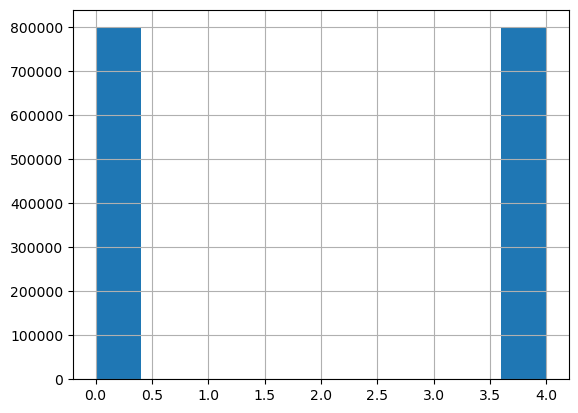

In [5]:
#Convert target to categorical
df_sentiment['target'] = pd.Categorical(df_sentiment.target)
df_sentiment['target'].unique()
df_sentiment['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot: >

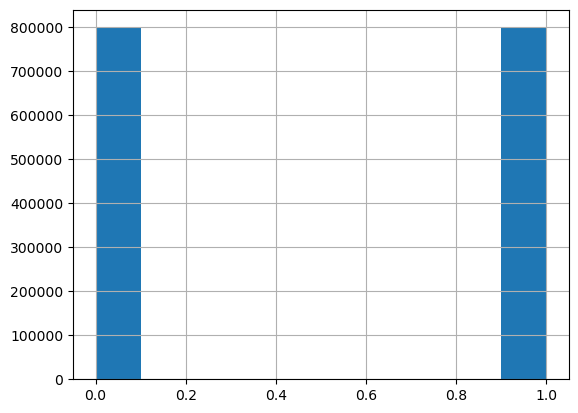

In [6]:
df_sentiment['target'] = df_sentiment['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df_sentiment['target'].hist()

<AxesSubplot: >

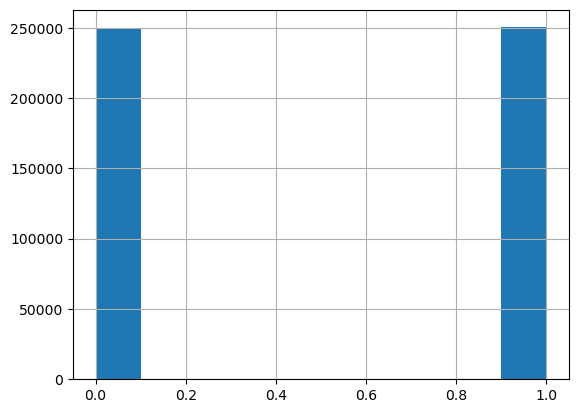

In [7]:
# For testing purposes, get a sample of the data
df_sentiment=df_sentiment.sample(500000)
df_sentiment['target'].hist()

## Hate Speech Data EDA

In [8]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [10]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot: >

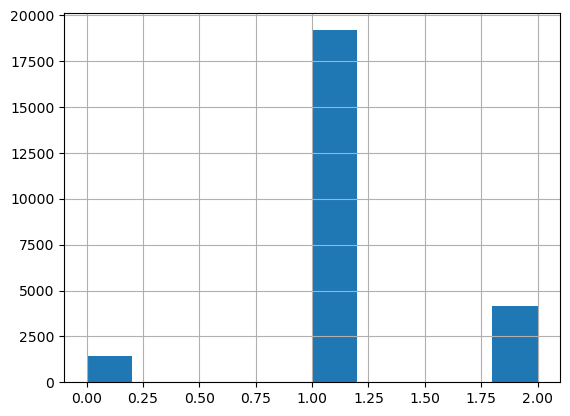

In [11]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

UPDATE THIS IF WE ARE FINALLY KEEPING NON_OFFENSIVE TWEETS
In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot: >

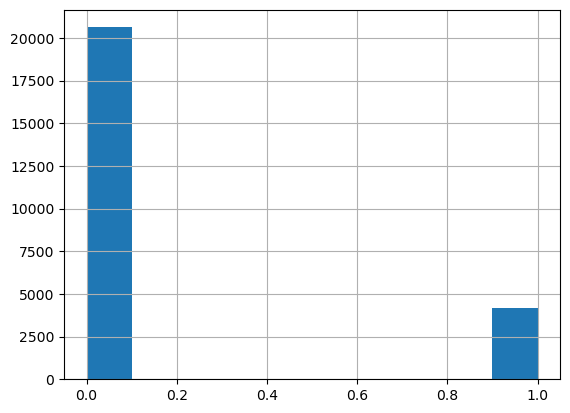

In [12]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [13]:
# Separate text from labels
X_hate=df_hate['text']
y_hate=df_hate['target']

## Train/ Test Split: Sentiment Data

In [14]:
# Split in training set and, testing set and separate labels from data
X_sentiment=df_sentiment['text']
y_sentiment=df_sentiment['target']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Split in training set and, testing set and separate labels from data
X_train, X_test, y_train, y_test= train_test_split(X_sentiment, y_sentiment, test_size = 1 - train_ratio, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=validation_ratio/(test_ratio + validation_ratio), random_state = 0)

len(X_train), len(X_val), len(X_test)

(375000, 75000, 50000)

## Build Data Cleaning Pipeline

In [15]:
cleaning=[('cleaner', FunctionTransformer(data_cleaning))] #TODO Add stop words param
data_cleaning_pipeline=Pipeline(cleaning)

### Apply Data Cleaning Pipeline on Sentiment Data

In [16]:
t1 = time.time()

X_train_clean=data_cleaning_pipeline.fit_transform(X_train)

t2 = time.time()
print(t2 - t1)

34.92875623703003


In [17]:
t1 = time.time()

X_val_clean=data_cleaning_pipeline.fit_transform(X_val)

t2 = time.time()
print(t2 - t1)

6.73432183265686


In [18]:
t1 = time.time()

X_test_clean=data_cleaning_pipeline.fit_transform(X_test)

t2 = time.time()
print(t2 - t1)

4.48137092590332


### Apply Data Cleaning Pipeline on Hate Speech Data

In [19]:
t1 = time.time()

X_hate_clean=data_cleaning_pipeline.fit_transform(X_hate)

t2 = time.time()
print(t2 - t1)

2.3121440410614014


## Naive Bayes Model

### Preprocessing Sentiment Data

##### Build TFIDF pipeline

In [20]:
# Build TfidfVectorizer Pipeline
tfidf=[('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
tfidf_pipeline=Pipeline(tfidf)

##### Appply TFIDF pipeline on Sentiment Data

In [21]:
#Apply TFIDF pipeline to the training set
t1 = time.time()

X_train_transformed=tfidf_pipeline.fit_transform(X_train_clean)

t2 = time.time()
print(t2 - t1)

9.378137111663818


In [22]:
#Apply TFIDF pipeline to the validation set
t1 = time.time()

X_val_transformed=tfidf_pipeline.fit_transform(X_val_clean)

t2 = time.time()
print(t2 - t1)

2.0749430656433105


In [23]:
#Apply TFIDF pipeline to the test set
t1 = time.time()

X_test_transformed=tfidf_pipeline.transform(X_test_clean)

t2 = time.time()
print(t2 - t1)

0.7724969387054443


### Train Sentiment Model

In [24]:
# Create a Naive Bayes model and fit the training data
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(X_train_transformed, y_train)

MultinomialNB()

### Evaluate Sentiment Model

In [25]:
# Generate Predictions for Trin and Test sets
nb_train_pred = naive_bayes_model.predict(X_train_transformed)
nb_test_pred = naive_bayes_model.predict(X_test_transformed)
nb_val_pred = naive_bayes_model.predict(X_val_transformed)

Results: Naive Bayes Model - sentiment, training set
Accuracy: 0.829208
F1: 0.8279984853489739
Precision: 0.8355492441693451
Recall: 0.8205829749180258

Results: Naive Bayes Model - sentiment, validation set
Accuracy: 0.49938666666666665
F1: 0.5453158302654524
Precision: 0.49902477946717494
Recall: 0.6010732019862246

Results: Naive Bayes Model - sentiment, testing set
Accuracy: 0.49602
F1: 0.5443960295792728
Precision: 0.4966843720101613
Recall: 0.6022481798543884


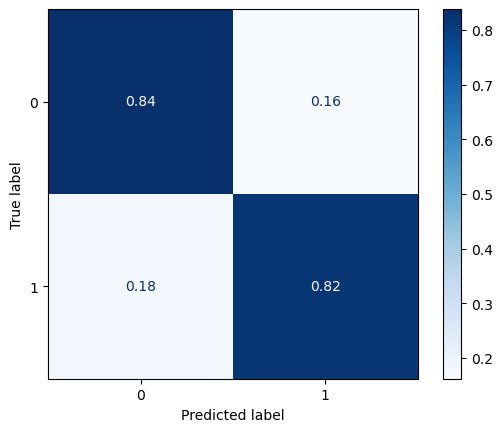

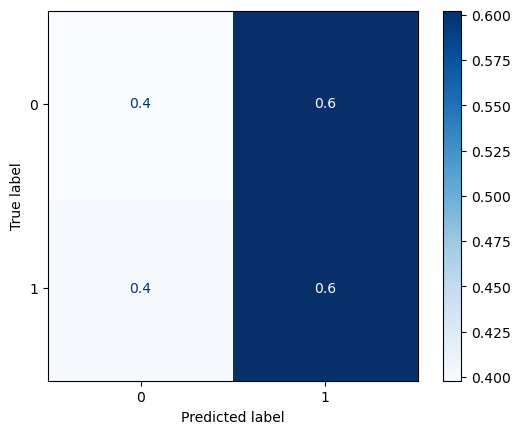

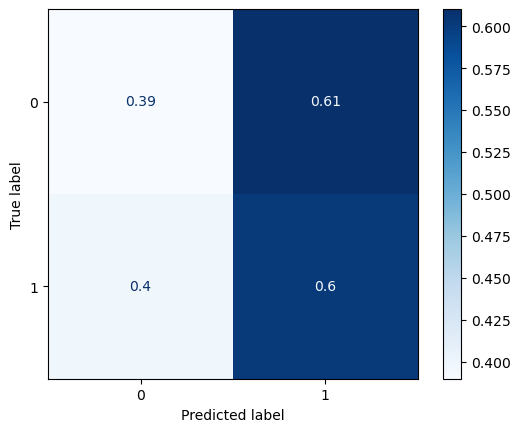

In [26]:
# Evaluate the Naive Bayes model
print("Results: Naive Bayes Model - sentiment, training set")
evaluate(y_train, nb_train_pred)
print()
print("Results: Naive Bayes Model - sentiment, validation set")
evaluate(y_val, nb_val_pred)
print()
print("Results: Naive Bayes Model - sentiment, testing set")
evaluate(y_test, nb_test_pred)

## Hate Speech Detection with Naive Bayes Model

In [27]:
#Apply TFIDF on Hate Speech data
t1 = time.time()

X_hate_transformed=tfidf_pipeline.transform(X_hate_clean)

t2 = time.time()
print(t2 - t1)

0.3894691467285156


In [28]:
# Generate predictions
t1 = time.time()

nb_hate_pred = naive_bayes_model.predict(X_hate_transformed)

t2 = time.time()
print(t2 - t1)

0.0030481815338134766


Accuracy: 0.4646330145664367
F1: 0.278520935290919
Precision: 0.18000984044422577
Recall: 0.6151813595964448


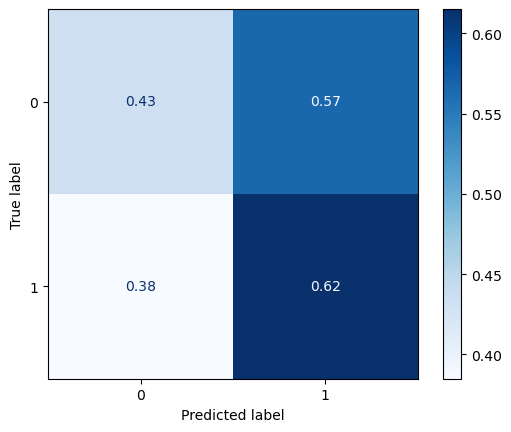

In [29]:
evaluate(y_hate, nb_hate_pred)

## LSTM 

In [30]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras import layers

### Preprocessing Sentiment Data

#### Preprocessing

In [31]:
tokenizer=Tokenizer() # change to the non-deprecated tf.keras.layers.TextVectorization 
tokenizer.fit_on_texts(X_train_clean)
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 227465


In [32]:
def lstm_preprocessing(X, y, tokenizer, maxlen = 40):
    X_processed = pad_sequences(tokenizer.texts_to_sequences(X), maxlen)
    y_processed = to_categorical(y)
    return (X_processed, y_processed)

# Apply preprocessing to train and validation sets
X_train_processed, y_train_processed = lstm_preprocessing(X_train_clean, y_train, tokenizer)
X_val_processed, y_val_processed = lstm_preprocessing(X_val_clean, y_val, tokenizer)

### Train Sentiment Model

In [33]:
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,\
                           output_dim=50,\
                           input_length=40)) 
model.add(layers.Dropout(0.5)) #added dropout layer to address overfitting
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

history = model.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=2,\
              validation_data=(X_val_processed,y_val_processed))

2022-12-06 15:27:19.421436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2
1465/1465 [==============================] - 146s 99ms/step - loss: 0.4749 - accuracy: 0.7733 - val_loss: 0.4261 - val_accuracy: 0.8023
Epoch 2/2
1465/1465 [==============================] - 161s 110ms/step - loss: 0.3966 - accuracy: 0.8199 - val_loss: 0.4184 - val_accuracy: 0.8066


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            11373250  
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 11,433,852
Trainable params: 11,433,852
Non-trainable params: 0
_________________________________________________________________


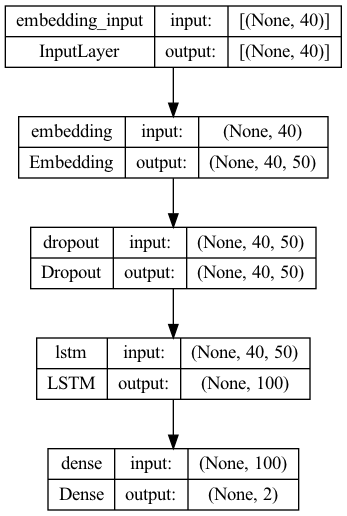

In [35]:
plot_model(model, 'test_plot.png', show_shapes=True)

### Evaluate Sentiment Model

In [36]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test_clean, y_test, tokenizer)

In [37]:
# Generate predictions for sentiment data
predictions_sentiment = model.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

1563/1563 [==============================] - 9s 6ms/step


Accuracy: 0.8051
F1: 0.8010534266990589
Precision: 0.8179695643110277
Recall: 0.7848227858228658


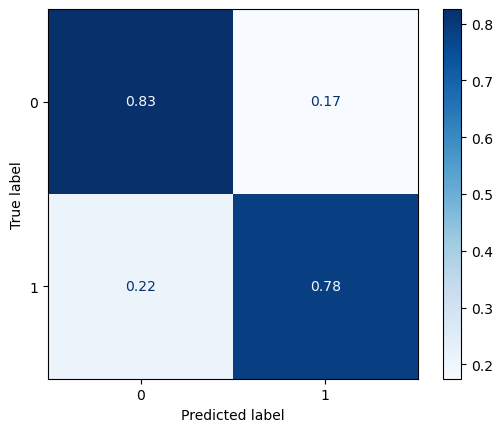

In [38]:
# Evaluate model on test data
evaluate(y_test, predictions_sentiment)

### Hate Speech Detection with LSTM Model

In [39]:
X_hate_processed, y_hate_processed = lstm_preprocessing(X_hate_clean, y_hate, tokenizer)

In [40]:
predictions_hate = model.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 4s 5ms/step


Accuracy: 0.4538595004640278
F1: 0.27655139237799986
Precision: 0.17784958064072598
Recall: 0.621426855632957


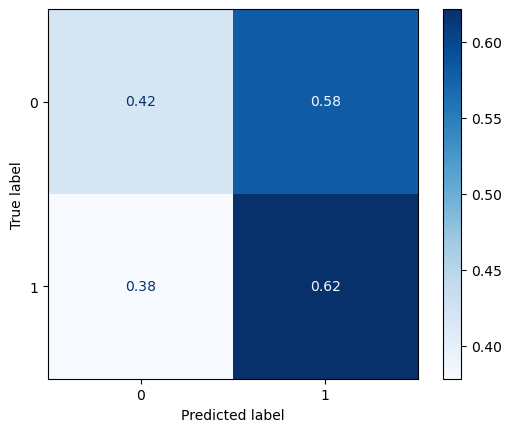

In [41]:
evaluate(y_hate, predictions_hate)

## VADER

In [42]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [46]:
def apply_vader(data, threshold = 0, plot = True, evaluate = True):
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
    if plot: 
        fig, ax = plt.subplots(figsize =(5, 3))
        ax.hist(data['vader'])
        plt.show()
    if evaluate: 
        data['predicted_target']=data.apply(lambda x: 0 if x['vader'] <= threshold else 1, axis=1)
        accuracy = accuracy_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        f1 = f1_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        precision = precision_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        recall = recall_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        plot_confusion_matrix(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        print(f'Accuracy: {accuracy}')    
        print(f'F1: {f1}')   
        print(f'Precision: {precision}')    
        print(f'Recall: {recall}')  

### VADER on Sentiment Data

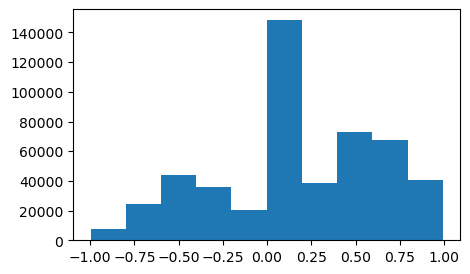

Accuracy: 0.652398
F1: 0.6432780465377851
Precision: 0.6615026783792112
Recall: 0.6260306807286673


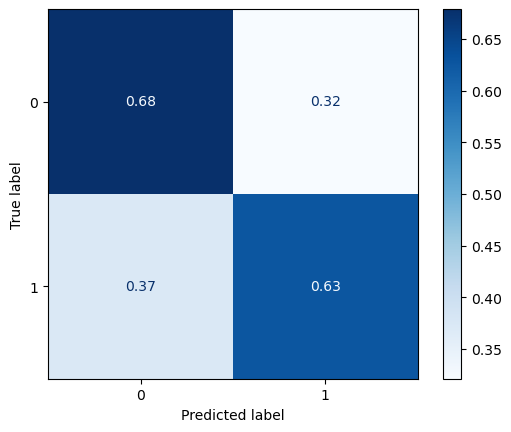

In [47]:
df_vader_sentiment = df_sentiment
apply_vader(df_vader_sentiment)

### VADER on Hate Speech Data

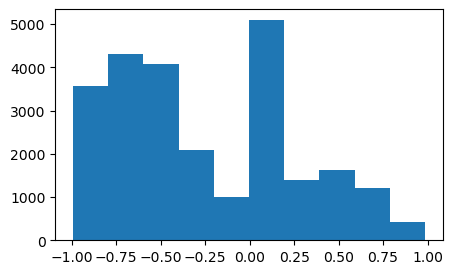

Accuracy: 0.7401041036194166
F1: 0.33823076132744273
Precision: 0.29551166965888687
Recall: 0.3953879413884218


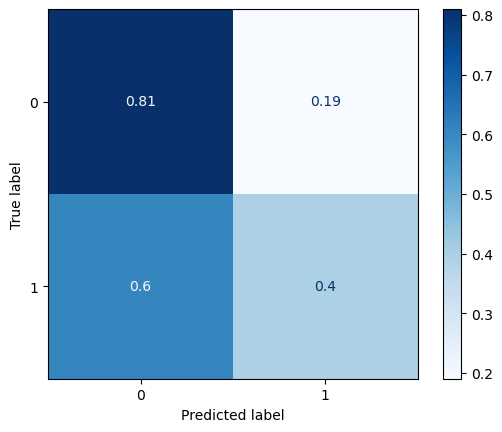

In [48]:
df_vader_hate = df_hate 
apply_vader(df_vader_hate)